This Notebook creates the necessary data for the CNN to use

In [3]:
#!pip3 install -U imageio
!pip install --upgrade pip
!pip install -U imutils

Requirement already up-to-date: pip in /usr/local/lib/python3.6/site-packages (18.1)
Requirement already up-to-date: imutils in /usr/local/lib/python3.6/site-packages (0.5.1)


In [4]:
#from scipy import misc
import glob
#import imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imutils
import cv2

**We load all images and mask/labels in alpha-numeric order in 2 separate arrays**

In [68]:
img_arr_img = []
img_arr_ref = []

filelist_img = glob.glob("/floyd/input/heart_challenge_insa/data/img/*.png")
filelist_ref = glob.glob("/floyd/input/heart_challenge_insa/data/ref/*.png")


for image_path in sorted(filelist_img):
    try:
        #print(image_path)
        image = cv2.imread(image_path)
        img_arr_img.append(image)
        #print(image)
        #break
    except (RuntimeError, TypeError,NameError) as e:
        print(e)
        #print(image.shape)
        #print(image.dtype)
        pass
    
for image_path in sorted(filelist_ref):
    try:
        #print(image_path)
        image = cv2.imread(image_path)
        img_arr_ref.append(image)
        #print(image)
        #break
    except (RuntimeError, TypeError,NameError) as e:
        print(e)
        #print(image.shape)
        #print(image.dtype)
        pass


Let's test and compare for different images

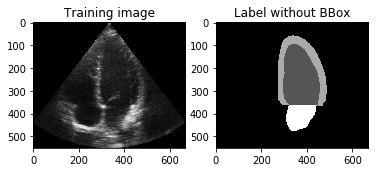

In [32]:
example_num = 356

plt.subplot(1, 2, 1)
plt.imshow(img_arr_img[example_num])
plt.title('Training image')
plt.subplot(1,2,2)
plt.imshow(img_arr_ref[example_num])
plt.title('Label without BBox')
plt.show()

Good! The 2 images match for different values of *example-num*

Perhaps a resize of all images is in order ?
I think yes, let's do it.

In [24]:
## this cell shows that the sizes differ
#for img in img_arr_img:
#    print(img.shape)
#for img in img_arr_ref:
#    print(img.shape)

In [46]:
new_size = 1024

img_arr_img = []
img_arr_ref = []

filelist_img = glob.glob("/floyd/input/heart_challenge_insa/data/img/*.png")
filelist_ref = glob.glob("/floyd/input/heart_challenge_insa/data/ref/*.png")


for image_path in sorted(filelist_img):
    try:
        #print(image_path)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (new_size, new_size))
        img_arr_img.append(image)
        #print(image)
        #break
    except (RuntimeError, TypeError,NameError) as e:
        print(e)
        #print(image.shape)
        #print(image.dtype)
        pass
    
for image_path in sorted(filelist_ref):
    try:
        #print(image_path)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (new_size, new_size))
        img_arr_ref.append(image)
        #print(image)
        #break
    except (RuntimeError, TypeError,NameError) as e:
        print(e)
        #print(image.shape)
        #print(image.dtype)
        pass


In [49]:
## this cell shows that the sizes are now all (1024,1024,3)
#for img in img_arr_img:
#    print(img.shape)
#for img in img_arr_ref:
#    print(img.shape)

Demonstration of the new sizes

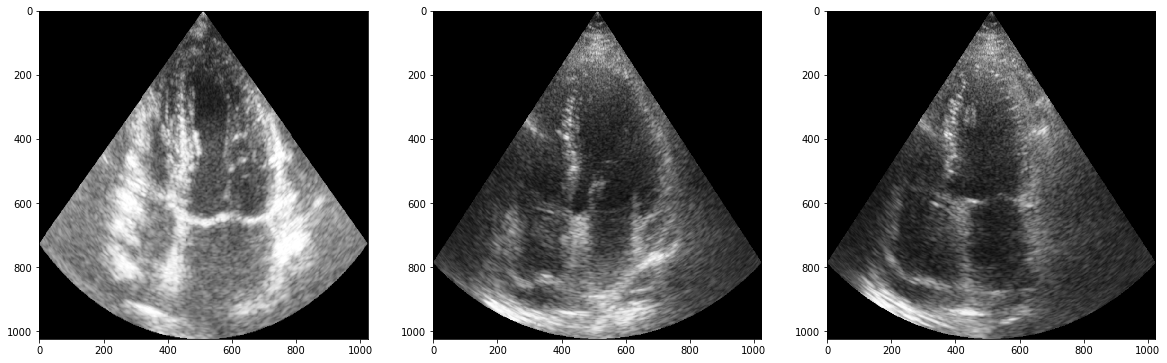

In [52]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_arr_img[i])
plt.show()

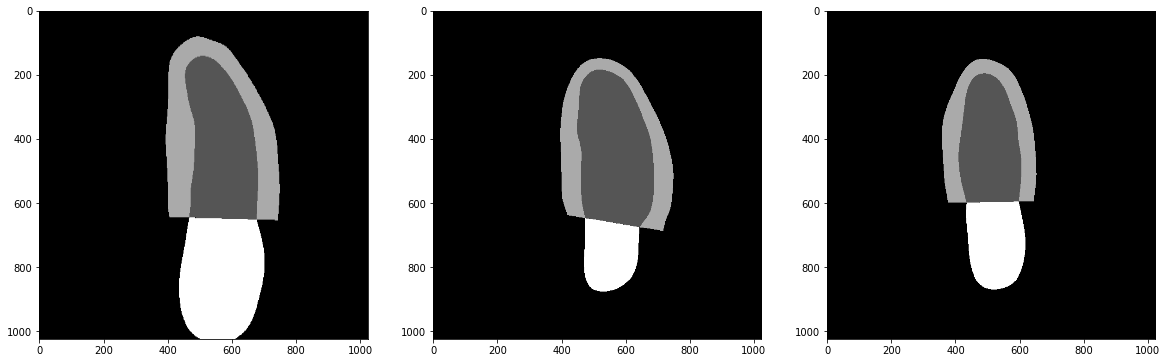

In [53]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_arr_ref[i])
plt.show()

Let's find out the BBox points for each of the data/ref mask/label images and put them in an array

In [69]:
bbox_points = []

for im_test in img_arr_ref:
    im_test[np.where((im_test==255).all(axis=2))] = 0 # On supprime le blanc ici
    gray = cv2.cvtColor(im_test, cv2.COLOR_BGR2GRAY)
    cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    c = max(cnts, key=cv2.contourArea)

    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Pt1 = (extLeft[0], extTop[1])
    #Pt2 = (extRight[0], extBot[1])
    bbox_points.append((extLeft[0], extTop[1],extRight[0], extBot[1]))
    
    ## Now we show the 2 diagonal points defining the BBox
    #cv2.circle(im_test, Pt1, 8, (0, 0, 255), -1)
    #cv2.circle(im_test, Pt2, 8, (0, 255, 0), -1)
    
    ## Show the BBox by uncommenting the following lines
    #cv2.rectangle(im_test, Pt1, Pt2, (0,255,0), 2)
    #plt.imshow(im_test)
    
#converting the bbox array to numpy array format
bbox_points = np.array(bbox_points)

Let's test that shit out

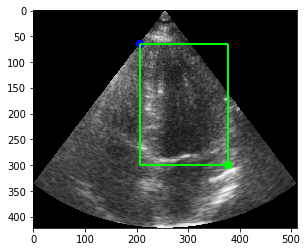

In [75]:
test_num = 303
im_test = img_arr_img[test_num]

## Now we show the 2 diagonal points defining the BBox
Pt1 = (bbox_points[test_num][0], bbox_points[test_num][1])
Pt2 = (bbox_points[test_num][2], bbox_points[test_num][3])

cv2.circle(im_test, Pt1, 8, (0, 0, 255), -1)
cv2.circle(im_test, Pt2, 8, (0, 255, 0), -1)
    
## Show the BBox by uncommenting the following lines
cv2.rectangle(im_test, Pt1, Pt2, (0,255,0), 2)
plt.imshow(im_test)

plt.imshow(im_test)

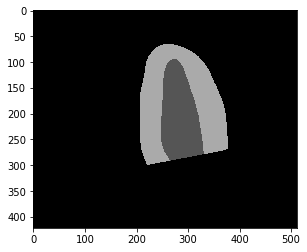

In [76]:
plt.imshow(img_arr_ref[test_num])

The resize affects the performance of the white are filter, we should definitely resize at the end ? 
**Maybe we shouldn't resize anything at all**

**Let's save bbox_points as pandas dataframe under labels_bbox.csv**

In [91]:
import os

df = pd.DataFrame(bbox_points, columns=["Point1_x", "Point1_y", "Point2_x", "Point2_y"])

labels_filepath = '{}'.format(os.getcwd())+'/data'

try:
    df.to_csv(labels_filepath+'/labels_bbox.csv')  
except FileNotFoundError as e:
    print(e)
    print('Lets create it')
    os.mkdir(labels_filepath)
    df.to_csv(labels_filepath+'/labels_bbox.csv') 
    print('File created under {}'.format(labels_filepath+'/labels_bbox.csv'))
    pass
except FileExistsError as e:
    print(e)
    print('File already existing, it will be replaced')
    os.mkdir(labels_filepath)
    df.to_csv(labels_filepath+'/labels_bbox.csv') 
    print('File created under {}'.format(labels_filepath+'/labels_bbox.csv'))
    pass



In [92]:
df.head()

,Point1_x,Point1_y,Point2_x,Point2_y
0,189,30,423,288
1,211,31,401,248
2,289,85,546,391
3,262,87,476,341
4,193,54,451,376


In [95]:
df.describe()

,Point1_x,Point1_y,Point2_x,Point2_y
count,600.000000,600.000000,600.000000,600.000000
mean,217.086667,67.433333,438.546667,343.198333
std,57.165015,21.570761,67.690727,41.760135
min,77.000000,20.000000,262.000000,228.000000
25%,182.750000,52.000000,399.000000,314.750000
50%,220.000000,65.000000,442.500000,343.000000
75%,252.000000,79.250000,480.250000,372.000000
max,518.000000,146.000000,756.000000,470.000000
